In [1]:
import keras
from keras import layers
import numpy as np
import os
import shutil    # os和shutil用来处理文件

Using TensorFlow backend.


# 对文件的常规处理

In [2]:
# 原始数据太多了，现在专门创建一个文件夹来存储一部分要用的训练集 + 测试集
base_dir = 'E:/Python_code/keras_total/日月光华-keras课程资料/dc/try'
train_dir = os.path.join(base_dir, 'train')
train_dir_dog = os.path.join(train_dir , 'dog')
train_dir_cat = os.path.join(train_dir , 'cat')

test_dir = os.path.join(base_dir , 'test')
test_dir_dog = os.path.join(test_dir , 'dog')
test_dir_cat = os.path.join(test_dir , 'cat')

dc_dir = 'E:/Python_code/keras_total/日月光华-keras课程资料/dc/train' # 原始数据所在路径

In [3]:
# 训练集猫狗各1000张，测试集猫狗各500张。
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(train_dir_dog)
    os.mkdir(train_dir_cat)
    os.mkdir(test_dir)
    os.mkdir(test_dir_dog)
    os.mkdir(test_dir_cat)

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname) 
        d = os.path.join(train_dir_cat, fname)
        shutil.copyfile(s, d)   #  把s拷贝到d 

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(test_dir_cat, fname)
        shutil.copyfile(s, d)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(train_dir_dog, fname)
        shutil.copyfile(s, d)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(test_dir_dog, fname)
        shutil.copyfile(s, d)

下面要进行的操作：
- 读取图片；
- 将图片解码；
- 预处理图片：因为图片大小不一，要把大小统一
- 图片归一化：数组里的数归一到[0,1]之间。

keras已经写好了专门进行“图片预处理”的模块，可以很方便的使用。

# 对数据的处理

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
# 创建图片的迭代器，并且设定它的归一化
train_datagen = ImageDataGenerator(1/255)
test_datagen = ImageDataGenerator(1/255)

In [6]:
# 正式创建图片的生成器：train
train_generator = train_datagen.flow_from_directory( train_dir,                  # 待读取文件的目录
                                                     target_size = (200,200),    # 图片的统一大小 
                                                     batch_size = 20,            # 每次读入20张
                                                     class_mode = 'binary'       # 该文件夹下分两类：因为我已经正好在该文件夹下分了两个文件夹
)

Found 2000 images belonging to 2 classes.


In [7]:
# 正式创建图片的生成器：test
test_generator = test_datagen.flow_from_directory( test_dir,                  # 待读取文件的目录
                                                    target_size = (200,200),    # 图片的统一大小 
                                                    batch_size = 20,            # 每次读入20张
                                                    class_mode = 'binary'       # 该文件夹下分两类：因为我已经正好在该文件夹下分了两个文件夹
)

Found 1000 images belonging to 2 classes.


# 模型创建

In [8]:
model = keras.Sequential()

In [9]:
from keras import layers

In [10]:
# 对于实际的图片数据，网络还是应该大一些！
model.add( layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(200,200,3)) )
model.add( layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu') )
model.add( layers.MaxPooling2D() )
model.add( layers.Dropout(0.25) )  # 防止过拟合

model.add( layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu') )
model.add( layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu') )
model.add( layers.MaxPooling2D() )
model.add( layers.Dropout(0.25) )  # 防止过拟合

model.add( layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu') )
model.add( layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu') )
model.add( layers.MaxPooling2D() )
model.add( layers.Dropout(0.25) )  # 防止过拟合

# 到了全连接层：
model.add( layers.Flatten() )
model.add( layers.Dense(256, activation='relu') )
model.add( layers.Dropout(0.5) )
model.add( layers.Dense(1, activation='sigmoid') )   # 二分类，输出层用sigmoid

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 64)       

In [12]:
model.compile( optimizer='adam',
               loss = 'binary_crossentropy',
               metrics=['acc']
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# 此时输入数据是“generator生成器”，所以用model.fit_generator
history = model.fit_generator( 
     # 训练数据：
     train_generator,
     epochs = 3,
     steps_per_epoch = 100,  # 有2000张图，每次录入20张，因此100步可以走完一个epoch！不设置的话，生成器会一直循环生成
     # 测试数据：
     validation_data = test_generator, 
     validation_steps = 50   # 有1000张图，每次录入20张，故50步即可走完一个epoch！
)


Epoch 1/3


e:\pycharm\python374\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 325s 3s/step - loss: 4.5162 - acc: 0.5065 - val_loss: 0.6918 - val_acc: 0.5000
Epoch 2/3
100/100 [==============================] - 320s 3s/step - loss: 0.6934 - acc: 0.5190 - val_loss: 0.6918 - val_acc: 0.5000
Epoch 3/3
100/100 [==============================] - 322s 3s/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6955 - val_acc: 0.5000


# 结果改进

只要是网络预测结果不好，最首先要考虑的是“**训练数据量够不够**”！！本例中训练数据每类只有1000张图，太少了。应该增多训练样本。

但如果样本只有这么多怎么办？ —— 可以使用图片数据的“**数据增强**”来人为的增多训练数据。

数据增强：就是在现有数据的基础上，对原始图片进行“**翻转、平移、扭曲、调明暗度**”等操作创造新的图像，从而增多的训练数据。

keras中已经自带了这些功能，这些操作具体调成什么样还需要人为的指定（默认是都不作调整）：

In [24]:
# 对读入的训练数据，进行数据增强：
train_datagen = ImageDataGenerator(
    rescale=1/255,                 # 还是归一化设置
    rotation_range=20,         # 随机旋转(0,20°)之间
    width_shift_range=0.2,  # 随机宽度平移距离(0,2,0.4) 
    height_shift_range=0.4, # 随机高度平移距离(0,2,0.4) 
    brightness_range=(0.6, 1),     # 随机明暗度调整
    shear_range=0.2,        # 扭曲
    zoom_range=0.4,          # 缩放            
    horizontal_flip=True,          # 随机水平翻转
    vertical_flip=True             # 随机垂向翻转
)  

# 不需要对测试数据进行图像增强！！ 因为测试东西就是我们要考察的，对它图像增强了就不是我们原来要考察的东西了。

In [25]:
# 可以看看随机图像增强后的结果：
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(200, 200),
                                                    batch_size=20,
                                                    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


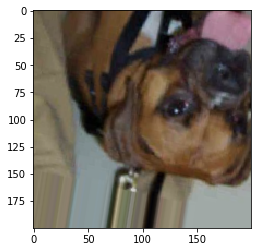

In [28]:
# 查看一些“随机图像增强”后的图：
import matplotlib.pyplot as plt

for im_batch in train_generator:
    for im in im_batch:
        plt.imshow(im[0,:])
        break
    break